In [ ]:
!pip install pycountry
!pip install pycountry-convert
!pip install wbdata
!pip install ipywidgets

In [331]:
import logging
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry


# Getting data

In [332]:
class HDIData:
    def __init__(self, filepath: str):
        """
        Initialize the HDIData object by loading a CSV file into a DataFrame.
        """
        # Read CSV safely
        self.df = pd.read_csv(filepath, encoding="ISO-8859-1")
        
        # Standardize column names
        self.df.columns = (
            self.df.columns
            .str.strip()
            .str.lower()
            .str.replace(' ', '_')
        )
    
    def _reshape_long(self, df, indicators: dict):
        """
        Converts wide-format year columns into long format for easier filtering.
        """
        id_vars = ['iso3', 'country', 'region']
        
        # Determine columns that match indicator prefixes
        value_vars = [
            col for col in df.columns 
            if any(col.startswith(prefix + "_") for prefix in indicators.keys())
        ]
        
        # Melt to long format
        long_df = df.melt(
            id_vars=id_vars,
            value_vars=value_vars,
            var_name='metric_year',
            value_name='value'
        )
        
        # Split 'metric_year' into 'metric' and 'year'
        long_df[['metric', 'year']] = long_df['metric_year'].str.rsplit('_', n=1, expand=True)
        long_df['year'] = long_df['year'].astype(int)
        long_df.drop(columns='metric_year', inplace=True)

        # Add readable metric names
        long_df['metric_name'] = long_df['metric'].map(indicators)
        
        return long_df

    def get_data(self, indicators: dict, countries=None, start_year=None, end_year=None):
        """
        Retrieve filtered data based on an indicator dictionary, countries, and year range.

        Args:
            indicators (dict): Dictionary of indicator IDs and readable names.
            countries (list or str): Country or list of countries to filter by.
            start_year (int): Start year for filtering.
            end_year (int): End year for filtering.
        """
        # Convert to long format using the indicators provided
        long_df = self._reshape_long(self.df, indicators)
        
        # Filter by countries
        if countries is not None:
            if isinstance(countries, str):
                countries = [countries]
            long_df = long_df[long_df['country'].str.lower().isin([c.lower() for c in countries])]
        
        # Filter by year range
        if start_year is not None:
            long_df = long_df[long_df['year'] >= start_year]
        if end_year is not None:
            long_df = long_df[long_df['year'] <= end_year]
        
        return long_df.reset_index(drop=True)


In [333]:
def load_indicators(indicators: dict, countries=None, years=None, folder_path='P5_Indicator'):
    """
    Load environmental/social indicators from CSV files and filter by country/year.

    Parameters
    ----------
    indicators : dict
        Dictionary mapping variable abbreviations to readable names, e.g.:
        {"BCA": "Biodiversity Conservation Area", "BER": "Biodiversity Expenditure Ratio"}.
    countries : str | list[str] | None
        Country or list of countries to filter.
    years : int | list[int] | tuple(int, int) | None
        Single year, list of years, or range (start, end) to filter.
    folder_path : str
        Path to the folder containing CSV files.

    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        ['country', 'iso', 'variable', 'variable_name', 'year', 'value']
    """
    all_dfs = []

    for var, var_name in indicators.items():
        filename = os.path.join(folder_path, f"{var}_ind_na.csv")
        if not os.path.exists(filename):
            raise FileNotFoundError(f"File {filename} not found.")
        
        # Load CSV safely
        df = pd.read_csv(filename)
        
        # Standardize columns
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        
        # Identify year columns for this variable (e.g., bca.ind.1990)
        year_cols = [col for col in df.columns if col.startswith(var.lower() + '.ind.')]
        
        # Melt wide -> long
        long_df = df.melt(
            id_vars=['iso', 'country'],
            value_vars=year_cols,
            var_name='metric_year',
            value_name='value'
        )
        
        # Extract year and add metadata
        long_df['year'] = long_df['metric_year'].str.split('.').str[-1].astype(int)
        long_df['variable'] = var
        long_df['variable_name'] = var_name
        long_df = long_df.drop(columns='metric_year')
        
        all_dfs.append(long_df)
    
    # Combine multiple indicators
    result = pd.concat(all_dfs, ignore_index=True)
    
    # Filter by countries
    if countries is not None:
        if isinstance(countries, str):
            countries = [countries]
        result = result[result['country'].str.lower().isin([c.lower() for c in countries])]
    
    # Filter by years
    if years is not None:
        if isinstance(years, tuple):  # range
            result = result[(result['year'] >= years[0]) & (result['year'] <= years[1])]
        elif isinstance(years, list):
            result = result[result['year'].isin(years)]
        else:  # single year
            result = result[result['year'] == years]
    
    return result.reset_index(drop=True)

In [334]:
def fetch_wbdata(indicators, countries="all", start_year=None, end_year=None):
    """
    Fetch World Bank data.

    Parameters:
        indicators (dict): Mapping from indicator code to descriptive name,
                           e.g. {'NY.GDP.MKTP.CD': 'GDP', 'SP.POP.TOTL': 'Population'}
        countries (list or str): ISO2 country codes like ['US', 'CN'], or 'all'
        start_year (int): Start year (optional)
        end_year (int): End year (optional)

    Returns:
        pd.DataFrame: DataFrame with columns ['Country', 'Year', ...indicators...]
    """
    # Handle date range
    if start_year and end_year:
        date_range = (
            datetime.datetime(start_year, 1, 1),
            datetime.datetime(end_year, 12, 31),
        )
    else:
        date_range = None

    # Fetch from World Bank
    df = wbdata.get_dataframe(
        indicators,
        country=countries,
        date=date_range,
        freq='Y',
        parse_dates=True
    )

    # Reset and clean DataFrame
    df = df.reset_index().rename(columns={"country": "Country", "date": "Year"})

    # Convert Year to integer if parsed as datetime
    if pd.api.types.is_datetime64_any_dtype(df["Year"]):
        df["Year"] = df["Year"].dt.year

    # Reorder columns: Country, Year, then indicators
    indicator_columns = list(indicators.values())
    cols = ["Country", "Year"] + indicator_columns
    df = df[[c for c in cols if c in df.columns]]

    return df

In [335]:
indicators_wb = { "4.1_SHARE.RE.IN.ELECTRICITY" : "renewable energy share",
                 "SH.H2O.BASW.ZS" :  "basic drinking water"}
indicators_yale = { "SPI" : "Species protection index",
              "SDA" : "Air Polution SO2 trend",
              "HPE" : "Ambient PM2.5 from human resources", 
              "MHP" : "Marine Habitat Protection"}
indicators_hdi = {"gii" : "GII",
                 "pr_f" : "Shares of seats in the parliament",
                 "lfpr_f" : "Labour force participation",
                 "se_f" : "population with secondary education"}


In [336]:
wbdata = fetch_wbdata(indicators_wb, countries="all", start_year=1990, end_year=2025)

In [337]:
hdi = HDIData("HDR25_Composite_indices_complete_time_series.csv")

hdi_data = hdi.get_data(
    indicators=indicators_hdi,
    countries=None,
    start_year=1990,
    end_year=2025
)

In [338]:
epi_data = load_indicators(
    indicators=indicators_yale,
    countries=None,
    years=(1990, 2025)
)

In [339]:
wbdata.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)

hdi_data_pivot = hdi_data.pivot_table(
    index=['country', 'year'],
    columns='metric_name',
    values='value'
).reset_index()

epi_data_pivot = epi_data.pivot_table(
    index=['country', 'year'],
    columns='variable_name',
    values='value'
).reset_index()

merged = (
    wbdata
    .merge(hdi_data_pivot, on=['country', 'year'], how='outer')
    .merge(epi_data_pivot, on=['country', 'year'], how='outer')
)

merged.rename(columns={
    'renewable energy share': 'Renewable_Energy_Share',
    'basic drinking water': 'Basic_Drinking_Water'
}, inplace=True)

# Data preprocessing

Some "countries' are actually regions so we could skip these (eg Euro zone, world, etc)

To get a standardized list of Country names we will be using pycountry. This library countrains an ISO list of country names. The use of pycountry was suggested and assisted by AI!

In [340]:
pycountry_names = set([c.name for c in pycountry.countries])

country_map = {}
for name in merged['country'].unique():
    if name in pycountry_names:
        country_map[name] = name

country_map.update({
    "Bahamas, The": "Bahamas",
    "Bolivia": "Bolivia, Plurinational State Of",
    "Bolivia (Plurinational State Of)": "Bolivia, Plurinational State Of",
    "Cape Verde": "Cabo Verde",
    "Congo": "Republic Of The Congo",
    "Congo (Democratic Republic Of The)": "Democratic Republic Of The Congo",
    "Congo, Dem. Rep.": "Democratic Republic Of The Congo",
    "Congo, Rep.": "Republic Of The Congo",
    "Cote D'Ivoire": "Côte D'Ivoire",
    "Czech Republic": "Czechia",
    "Dem. Rep. Congo": "Democratic Republic Of The Congo",
    "Egypt, Arab Rep.": "Egypt",
    "Eswatini (Kingdom Of)": "Eswatini",
    "French Guyana": "French Guiana",
    "Gambia, The": "Gambia",
    "The Gambia": "Gambia",
    "Hong Kong Sar, China": "Hong Kong",
    "Hong Kong, China (Sar)": "Hong Kong",
    "Iran": "Iran, Islamic Republic Of",
    "Iran (Islamic Republic Of)": "Iran, Islamic Republic Of",
    "Iran, Islamic Rep.": "Iran, Islamic Republic Of",
    "Korea (Democratic People's Rep. Of)": "Korea, Democratic People's Republic Of",
    "Korea (Republic Of)": "Korea, Republic Of",
    "Korea, Dem. People's Rep.": "Korea, Democratic People's Republic Of",
    "Korea, Dem. Rep.": "Korea, Democratic People's Republic Of",
    "Korea, Rep.": "Korea, Republic Of",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao Pdr": "Lao People's Democratic Republic",
    "Lao People's Democratic Republic": "Lao People's Democratic Republic",
    "Laos": "Lao People's Democratic Republic",
    "Macedonia, Fyr": "North Macedonia",
    "Macao": "Macao SAR, China",
    "Macao SAR, China": "Macao SAR, China",
    "Micronesia": "Micronesia, Federated States Of",
    "Micronesia (Federated States Of)": "Micronesia, Federated States Of",
    "Micronesia, Fed. Sts.": "Micronesia, Federated States Of",
    "Moldova": "Moldova, Republic Of",
    "Moldova (Republic Of)": "Moldova, Republic Of",
    "North Korea": "Korea, Democratic People's Republic Of",
    "Puerto Rico (US)":"Puerto Rico",
    "Republic Of Congo": "Republic Of The Congo",
    "Russia": "Russian Federation",
    "Slovak Republic": "Slovakia",
    "Syria": "Syrian Arab Republic",
    "Taiwan, China": "Taiwan, Province Of China",
    "Tanzania (United Republic Of)": "Tanzania, United Republic Of",
    "Turkey": "Türkiye",
    "Turkiye": "Türkiye",
    "Timor-Leste": "East Timor",
    "United States of America": "United States",
    "Venezuela": "Venezuela, Bolivarian Republic Of",
    "Venezuela (Bolivarian Republic Of)": "Venezuela, Bolivarian Republic Of",
    "Venezuela, Rb": "Venezuela, Bolivarian Republic Of",
    "Vietnam": "Viet Nam",
    "Yemen, Rep.": "Yemen"
})

merged = merged.copy()
merged['country'] = merged['country'].map(country_map)
merged = merged.dropna(subset=['country'])
merged = merged.groupby(['country', 'year'], as_index=False).first()

Will make a continent variable in case that is interesting to us.

In [341]:
import pycountry
import pycountry_convert

def get_continent(country_name):
    try:
        # Try to find the country by exact name first
        country = pycountry.countries.get(name=country_name)
        
        # If not found, try fuzzy search
        if country is None:
            country = pycountry.countries.search_fuzzy(country_name)[0]
        
        # Get ISO Alpha-2 code
        country_code = country.alpha_2
        
        # Convert to continent code and name
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_code)
        continent_name = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
        
        return continent_name

    except Exception:
        return 'Unknown'

# Apply to your DataFrame
merged['continent'] = merged['country'].apply(get_continent)

print(merged[['country', 'continent']].head())


       country continent
0  Afghanistan      Asia
1  Afghanistan      Asia
2  Afghanistan      Asia
3  Afghanistan      Asia
4  Afghanistan      Asia


In [342]:
unknown_continent_countries = merged[
    (merged['continent'].isna()) | (merged['continent'] == 'Unknown')
][['country']].drop_duplicates()

print(unknown_continent_countries)

                               country
1741  Democratic Republic Of The Congo
1916                        East Timor
4065                  Macao SAR, China
6280         Sint Maarten (Dutch part)
7519                    Western Sahara


In [343]:
merged.loc[merged["country"] == "East Timor", "continent"] = "Asia"

Will not use these.

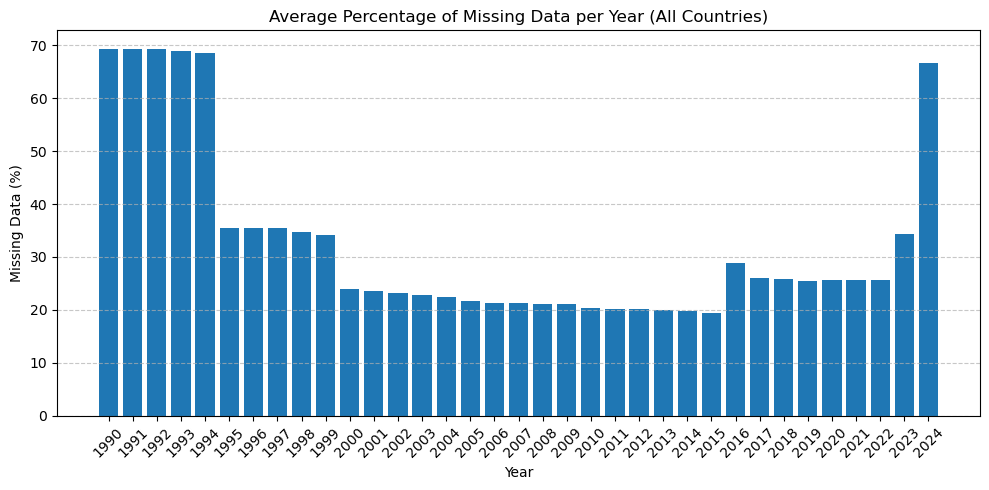

In [344]:
# Exclude trivial columns
cols_to_check = [c for c in merged.columns if c not in ['year', 'country', 'continent']]

# 1️⃣ Percentage of NaN values per year (average across all countries and columns)
nan_by_year = merged.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [345]:
merged = merged[(merged['year'] >= 2000) & (merged['year'] <= 2022)]

In [346]:
merged[(merged["country"]=="United States") & (merged["year"]==2019)]

,country,year,Renewable_Energy_Share,Basic_Drinking_Water,GII,Labour force participation,Shares of seats in the parliament,population with secondary education,Air Polution SO2 trend,Ambient PM2.5 from human resources,Marine Habitat Protection,Species protection index,continent
7316,United States,2019,NaN,99.744631,0.191,57.43,23.728814,97.65097,100.0,62.5,46.1,27.3,North America


In [354]:
nan_by_country = merged.groupby('country')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

print(f"Top 30 countries with the least data (% of missing values):")
print(nan_by_country.head(50))

Top 30 countries with the least data (% of missing values):
country
Central African Republic            33.043478
Lao People's Democratic Republic    30.000000
Chad                                29.130435
Palau                               28.695652
Seychelles                          27.391304
Guinea-Bissau                       26.521739
Grenada                             26.521739
Dominica                            25.652174
Yemen                               25.217391
Djibouti                            24.347826
Bhutan                              23.913043
Libya                               23.913043
Ukraine                             23.043478
Syrian Arab Republic                23.043478
Turkmenistan                        23.043478
Marshall Islands                    22.608696
Afghanistan                         22.173913
Madagascar                          21.304348
Myanmar                             20.434783
North Macedonia                     20.000000
Cabo Verde  

In [348]:
print(len(merged["country"].unique()))

221


In [352]:
def nan_mean_excluding_marine(x):
    # Exclude 'Marine Habitat Protection' if all NaN for this country
    if 'Marine Habitat Protection' in x.columns and x['Marine Habitat Protection'].isna().all():
        return x.drop(columns=['Marine Habitat Protection']).isna().mean().mean() * 100
    else:
        return x.isna().mean().mean() * 100

# Compute missing-data percentage per country
country_nan_percent = merged.groupby('country')[cols_to_check].apply(nan_mean_excluding_marine)

# Keep only countries with <= 30% missing data
valid_countries = country_nan_percent[country_nan_percent <= 30].index

# Filter the main DataFrame
merged = merged[merged['country'].isin(valid_countries)]

In [353]:
print(len(merged["country"].unique()))

167


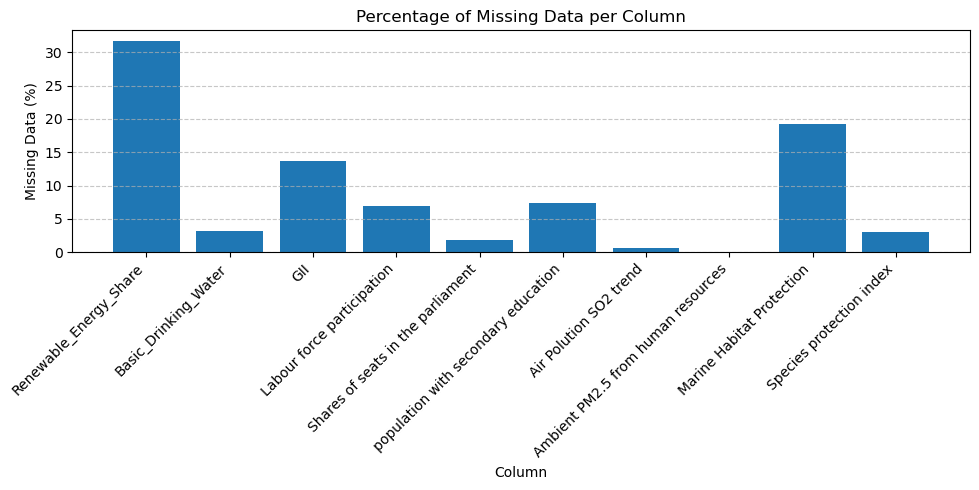


Missing data percentage per column:
Renewable_Energy_Share                 31.691985
Marine Habitat Protection              19.277108
GII                                    13.672080
population with secondary education     7.412258
Labour force participation              6.993190
Basic_Drinking_Water                    3.169199
Species protection index                3.012048
Shares of seats in the parliament       1.833421
Air Polution SO2 trend                  0.602410
Ambient PM2.5 from human resources      0.000000
dtype: float64


In [326]:
# 3️⃣ Missing data per column (excluding trivial ones)
nan_per_column = merged[cols_to_check].isna().mean() * 100

plt.figure(figsize=(10,5))
plt.bar(nan_per_column.index, nan_per_column.values)
plt.title('Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column:")
print(nan_per_column.sort_values(ascending=False))

# Basic Stats

basic stats & missing values (fill missing values or exclude?)
What does the data mean, what values can it obtain / normalization

In [355]:
merged.info()
merged.describe()
merged.isna().sum()

<class 'wbdata.client.DataFrame'>
Index: 3841 entries, 10 to 7656
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              3841 non-null   object 
 1   year                                 3841 non-null   int64  
 2   Renewable_Energy_Share               2624 non-null   float64
 3   Basic_Drinking_Water                 3720 non-null   float64
 4   GII                                  3296 non-null   float64
 5   Labour force participation           3551 non-null   float64
 6   Shares of seats in the parliament    3771 non-null   float64
 7   population with secondary education  3558 non-null   float64
 8   Air Polution SO2 trend               3818 non-null   float64
 9   Ambient PM2.5 from human resources   3841 non-null   float64
 10  Marine Habitat Protection            3082 non-null   float64
 11  Species protection index             3

country                                   0
year                                      0
Renewable_Energy_Share                 1217
Basic_Drinking_Water                    121
GII                                     545
Labour force participation              290
Shares of seats in the parliament        70
population with secondary education     283
Air Polution SO2 trend                   23
Ambient PM2.5 from human resources        0
Marine Habitat Protection               759
Species protection index                115
continent                                 0
dtype: int64

# Data visualization/exploration

### Renewable energy share

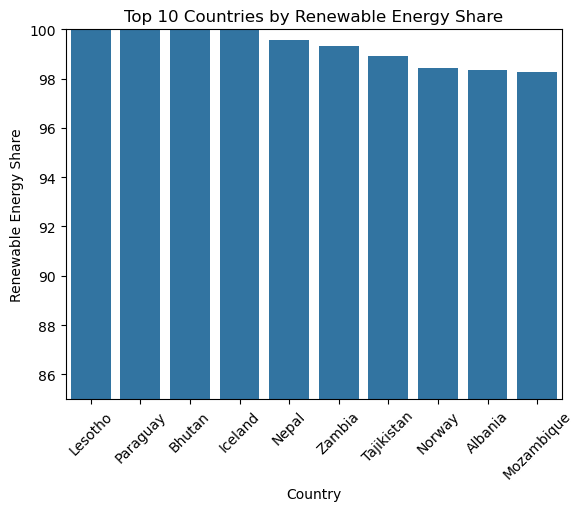

In [269]:
top_countries = merged.groupby('country')['Renewable_Energy_Share'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Renewable Energy Share')
plt.ylabel('Renewable Energy Share')
plt.ylim(85, 100)
plt.xlabel('Country')
plt.show()

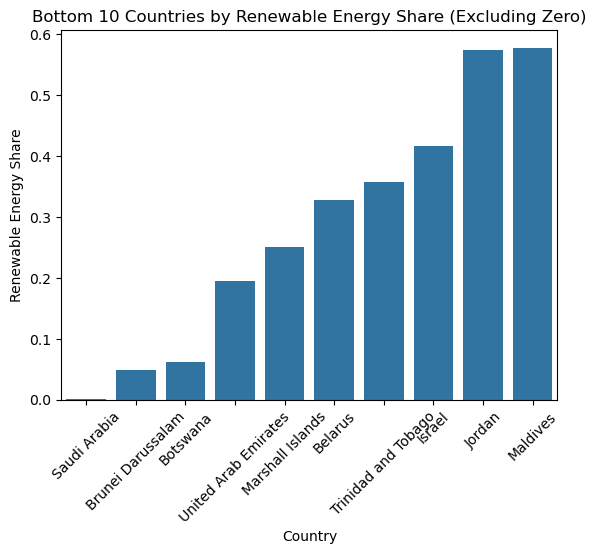

In [270]:
bottom_countries = (
    merged[merged['Renewable_Energy_Share'] > 0]
    .groupby('country')['Renewable_Energy_Share']
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by Renewable Energy Share (Excluding Zero)')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Country')
plt.show()

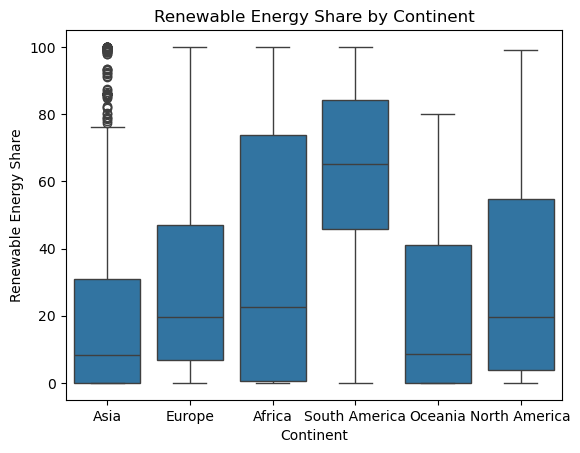

In [275]:
sns.boxplot(data=merged, x='continent', y='Renewable_Energy_Share')
plt.title('Renewable Energy Share by Continent')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Continent')
plt.show()

### GII

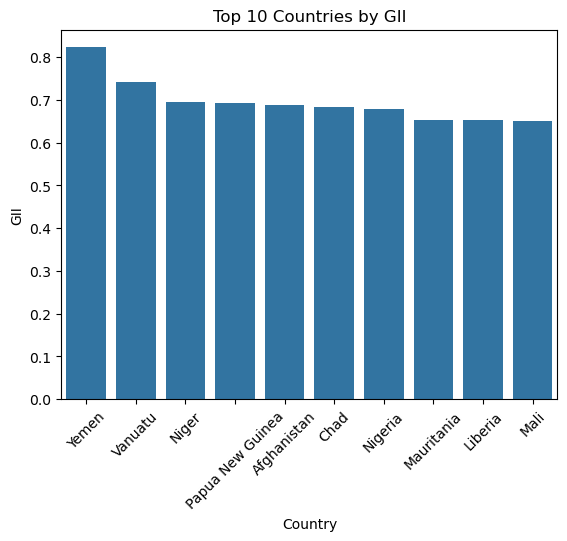

In [252]:
top_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

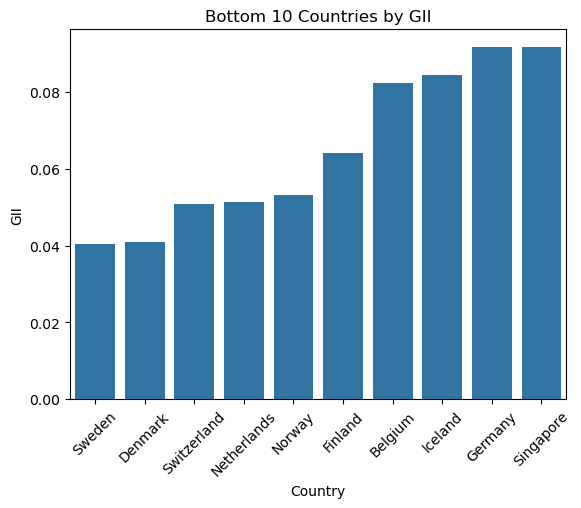

In [253]:
bottom_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=True).head(10)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

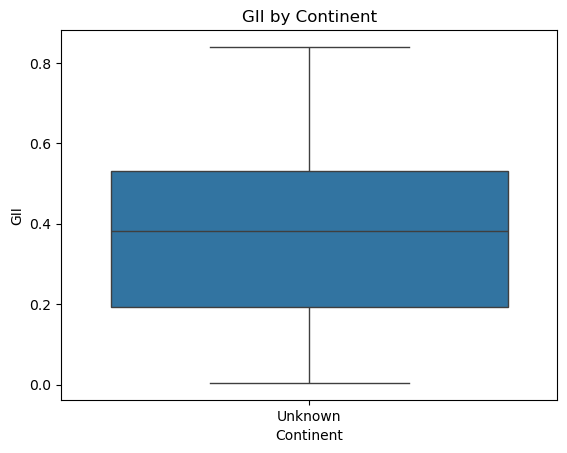

In [254]:
sns.boxplot(data=merged, x='continent', y='GII')
plt.title('GII by Continent')
plt.ylabel('GII')
plt.xlabel('Continent')
plt.show()

### Let's see their relation

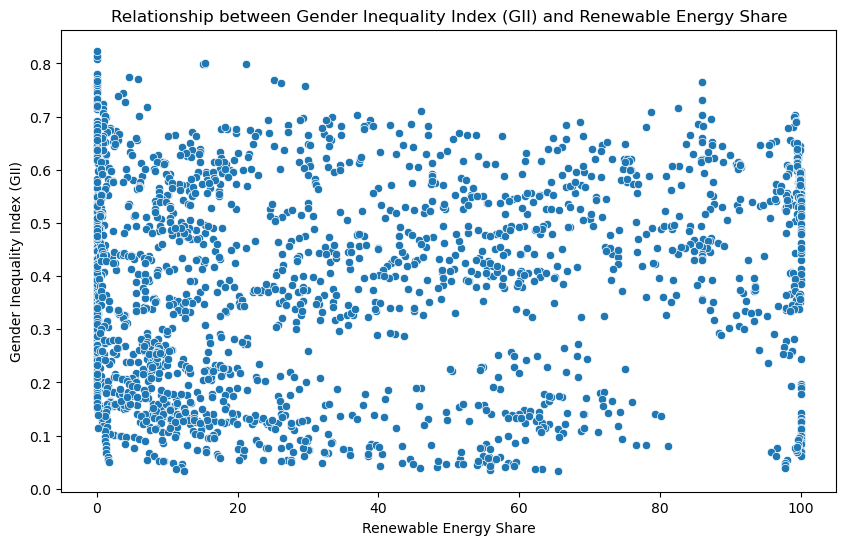

In [255]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged, x='Renewable_Energy_Share', y='GII', legend=True)
plt.title('Relationship between Gender Inequality Index (GII) and Renewable Energy Share')
plt.xlabel('Renewable Energy Share')
plt.ylabel('Gender Inequality Index (GII)')
plt.show()

### Correlation exploration

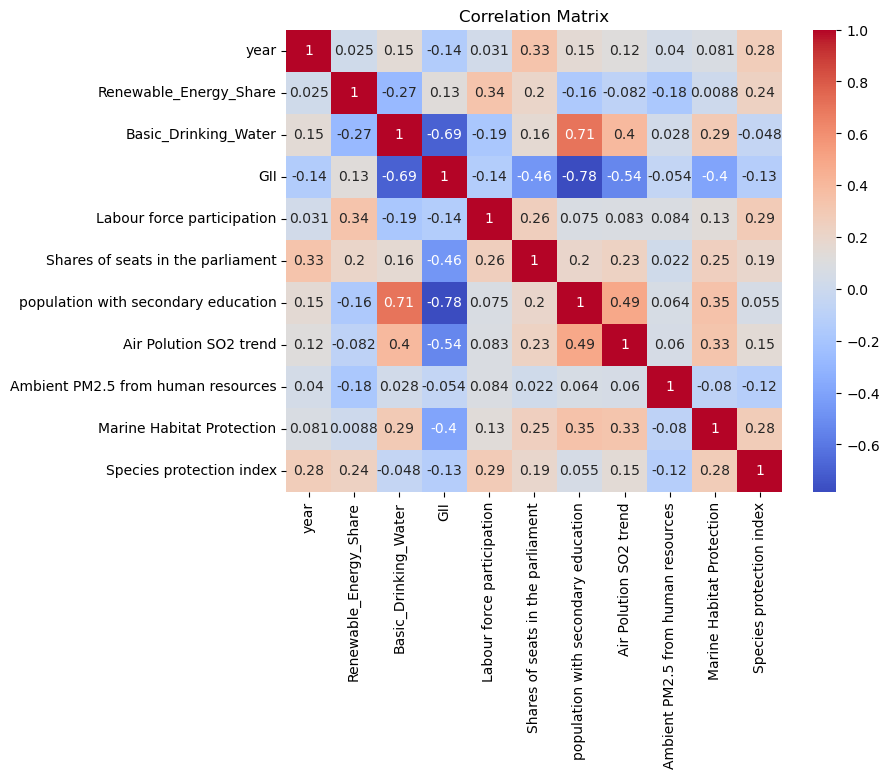

In [256]:
plt.figure(figsize=(8,6))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

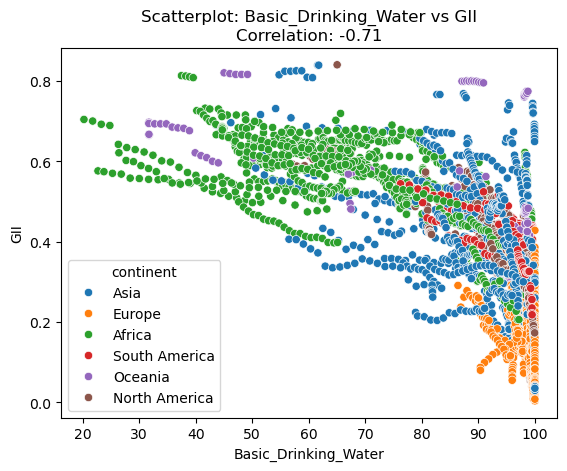

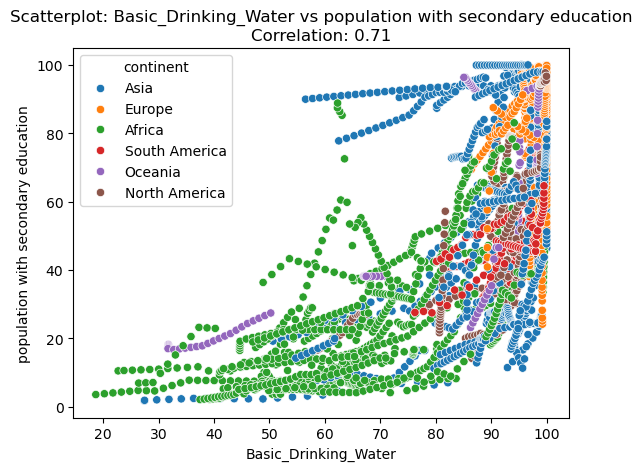

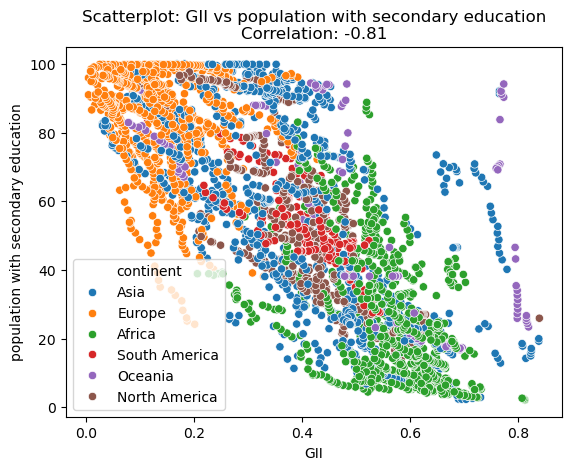

In [277]:
corr = merged[merged["year"]==2022].corr(numeric_only=True)

# Relationships with correlation > 0.7
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and abs(corr.loc[col1, col2]) > 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

for col1, col2 in high_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

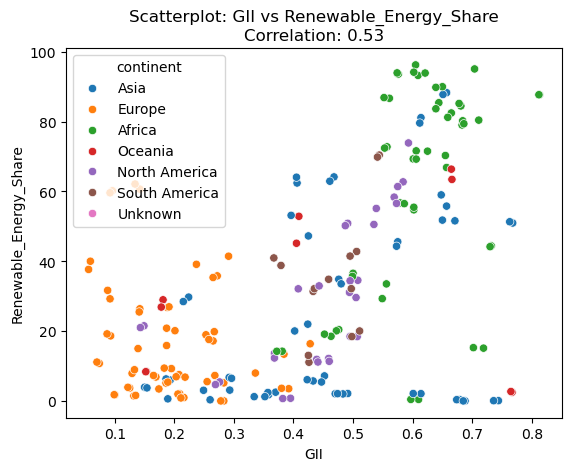

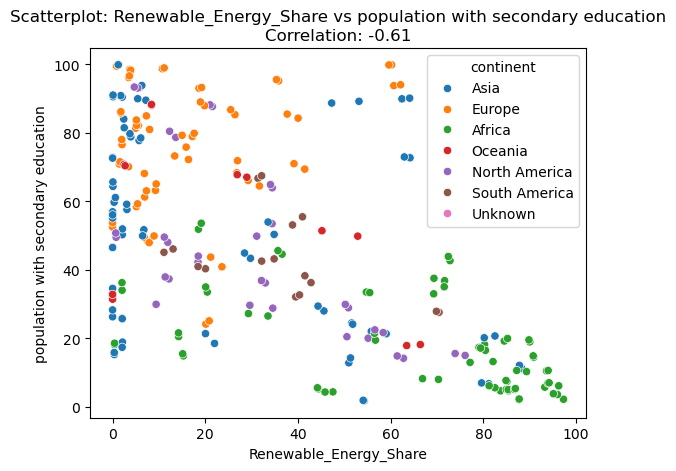

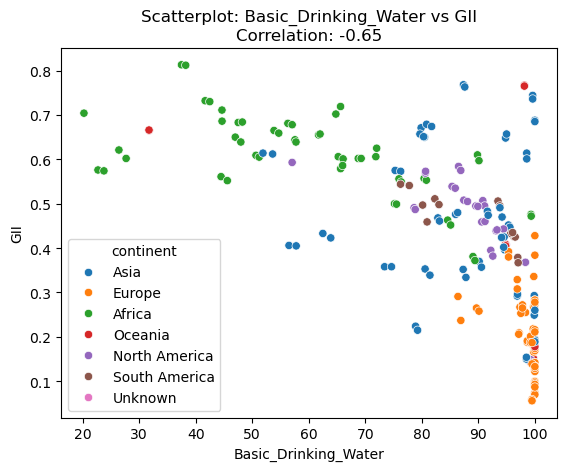

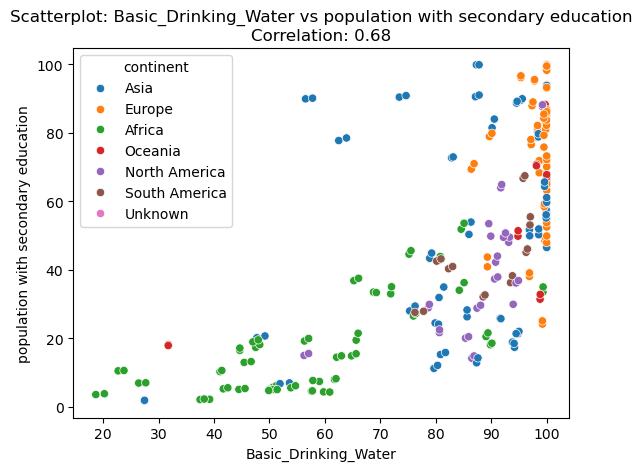

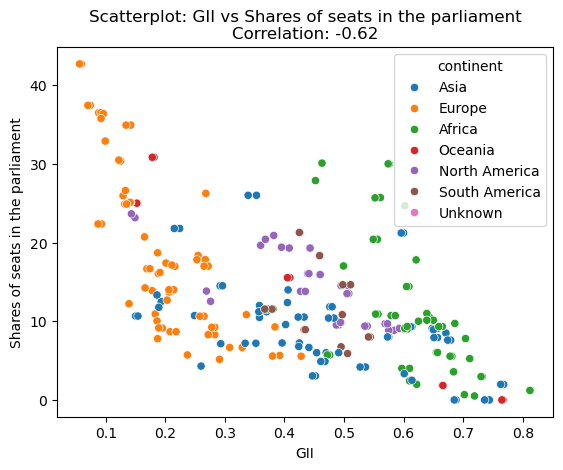

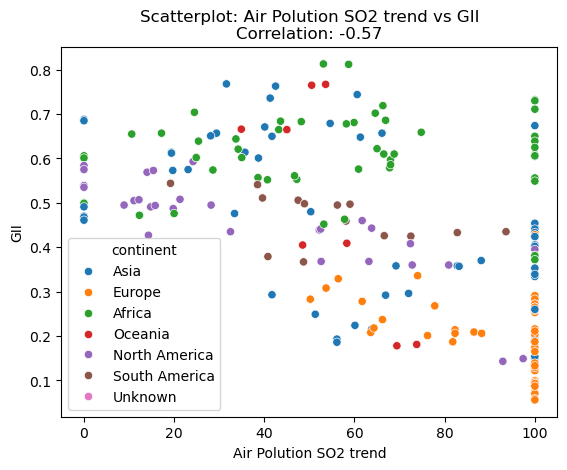

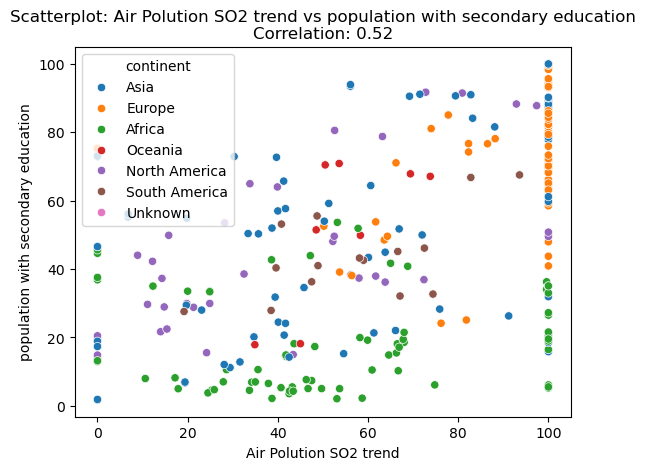

In [29]:
corr = merged.corr(numeric_only=True)

# Relationships with 0.5 < correlation <= 0.7
medium_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and 0.5 < abs(corr.loc[col1, col2]) <= 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in medium_corr:
                medium_corr.append(pair)

for col1, col2 in medium_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

# Exploratory Analysis
## Basic info & missing values

## Distribution and Outliers

array([[<Axes: title={'center': 'Renewable_Energy_Share'}>,
        <Axes: title={'center': 'Basic_Drinking_Water'}>,
        <Axes: title={'center': 'GII'}>],
       [<Axes: title={'center': 'Labour force participation'}>,
        <Axes: title={'center': 'Shares of seats in the parliament'}>,
        <Axes: title={'center': 'population with secondary education'}>],
       [<Axes: title={'center': 'Air Polution SO2 trend'}>,
        <Axes: title={'center': 'Ambient PM2.5 from human resources'}>,
        <Axes: title={'center': 'Marine Habitat Protection'}>],
       [<Axes: title={'center': 'Species protection index'}>, <Axes: >,
        <Axes: >]], dtype=object)

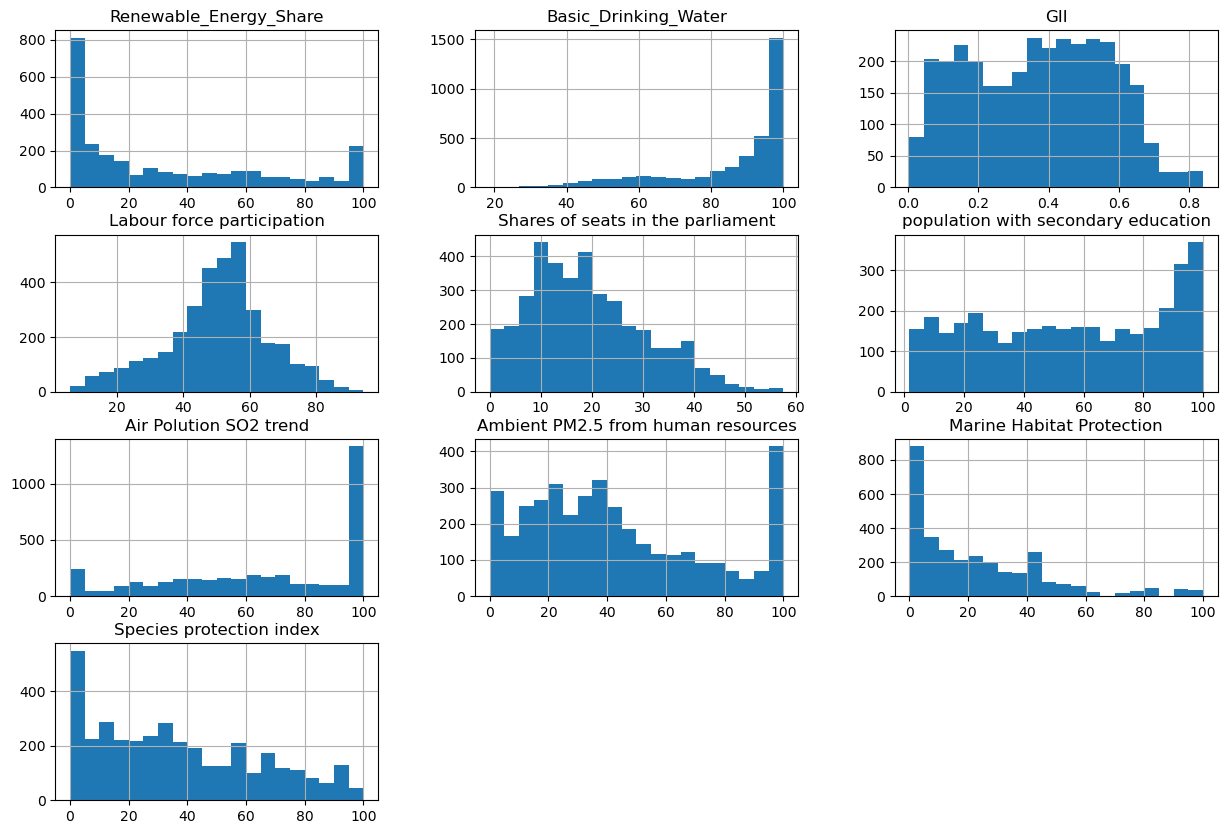

In [278]:
numeric_cols = ['Renewable_Energy_Share', 'Basic_Drinking_Water', 'GII',
                'Labour force participation', 'Shares of seats in the parliament',
                'population with secondary education', 'Air Polution SO2 trend',
                'Ambient PM2.5 from human resources', 'Marine Habitat Protection',
                'Species protection index']

merged[numeric_cols].hist(figsize=(15,10), bins=20)


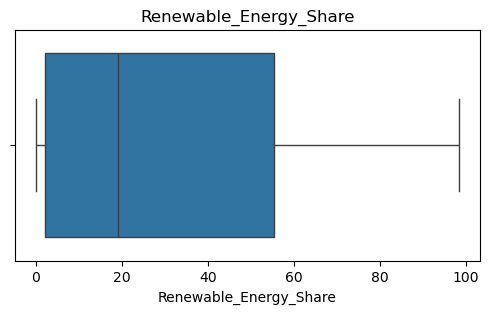

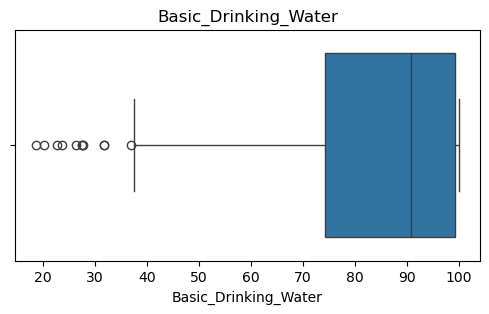

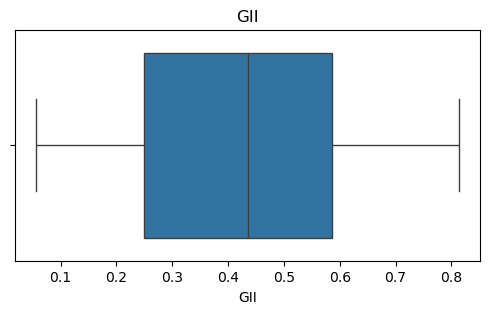

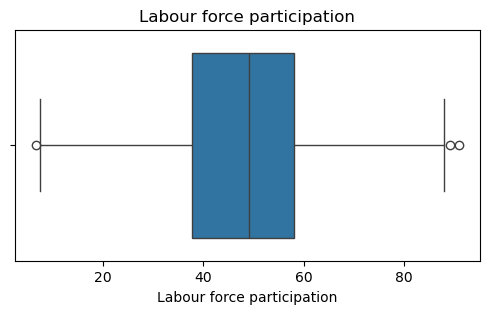

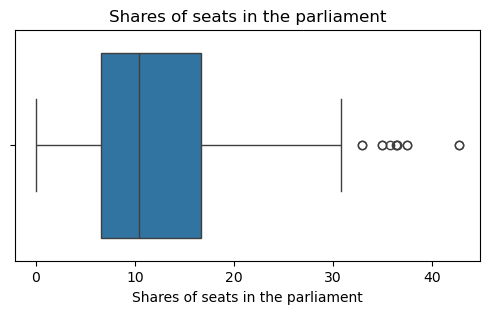

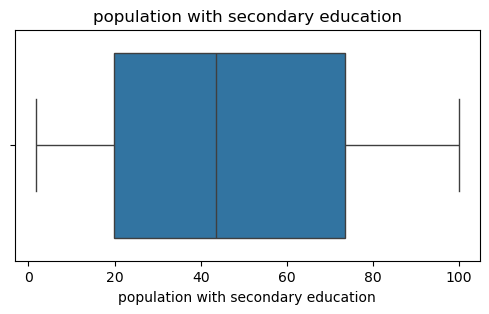

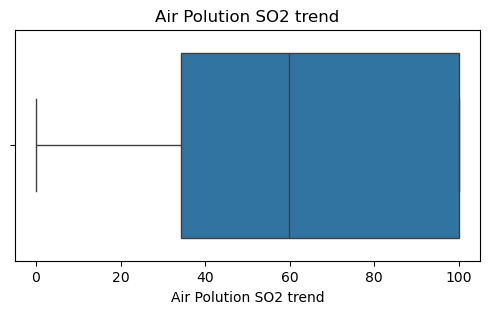

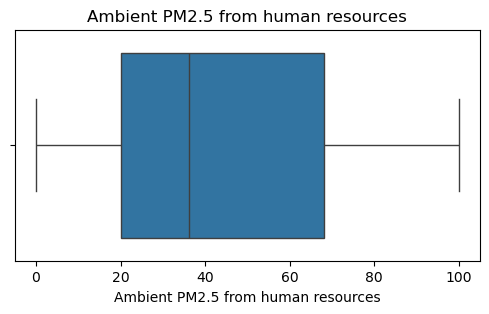

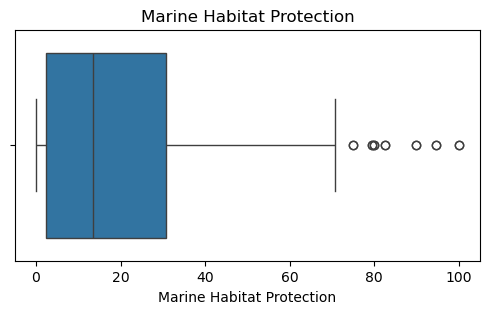

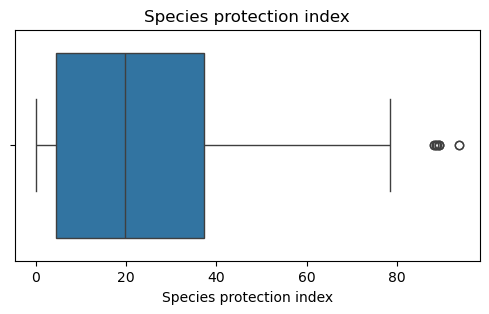

In [32]:
# boxplot to check for outliers
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=merged[col])
    plt.title(col)
    plt.show()

## Temporal trends

C:\Users\lukav\AppData\Local\Temp\ipykernel_24708\3538017753.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df['GII'] = country_df['GII'] * 100


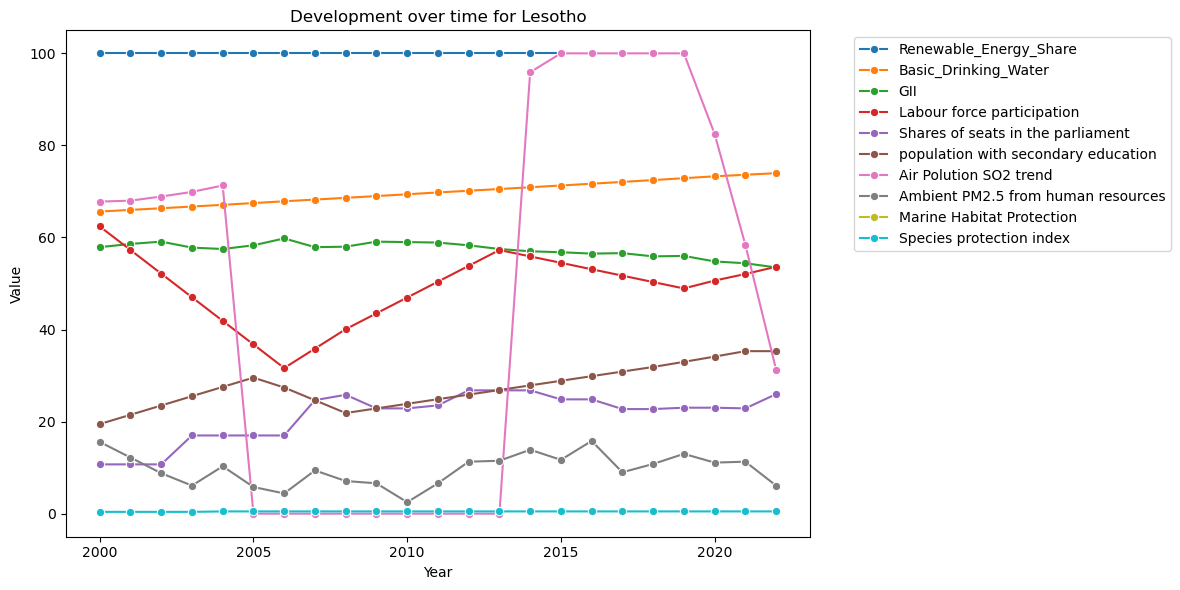

In [290]:
country_name = 'Lesotho'  

country_df = merged[merged['country'] == country_name]

# Multiply 'gii' by 100 if it exists
if 'GII' in country_df.columns:
    country_df['GII'] = country_df['GII'] * 100

numeric_cols = country_df.select_dtypes(include='number').columns.tolist()
numeric_cols.remove('year')  

plot_df = country_df.melt(id_vars='year', value_vars=numeric_cols, 
                          var_name='Indicator', value_name='Value')

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_df, x='year', y='Value', hue='Indicator', marker='o')
plt.title(f'Development over time for {country_name}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()


In [34]:
print(merged.columns)


Index(['country', 'year', 'Renewable_Energy_Share', 'Basic_Drinking_Water',
       'GII', 'Labour force participation',
       'Shares of seats in the parliament',
       'population with secondary education', 'Air Polution SO2 trend',
       'Ambient PM2.5 from human resources', 'Marine Habitat Protection',
       'Species protection index', 'country_iso', 'continent'],
      dtype='object')


## GII Correlation

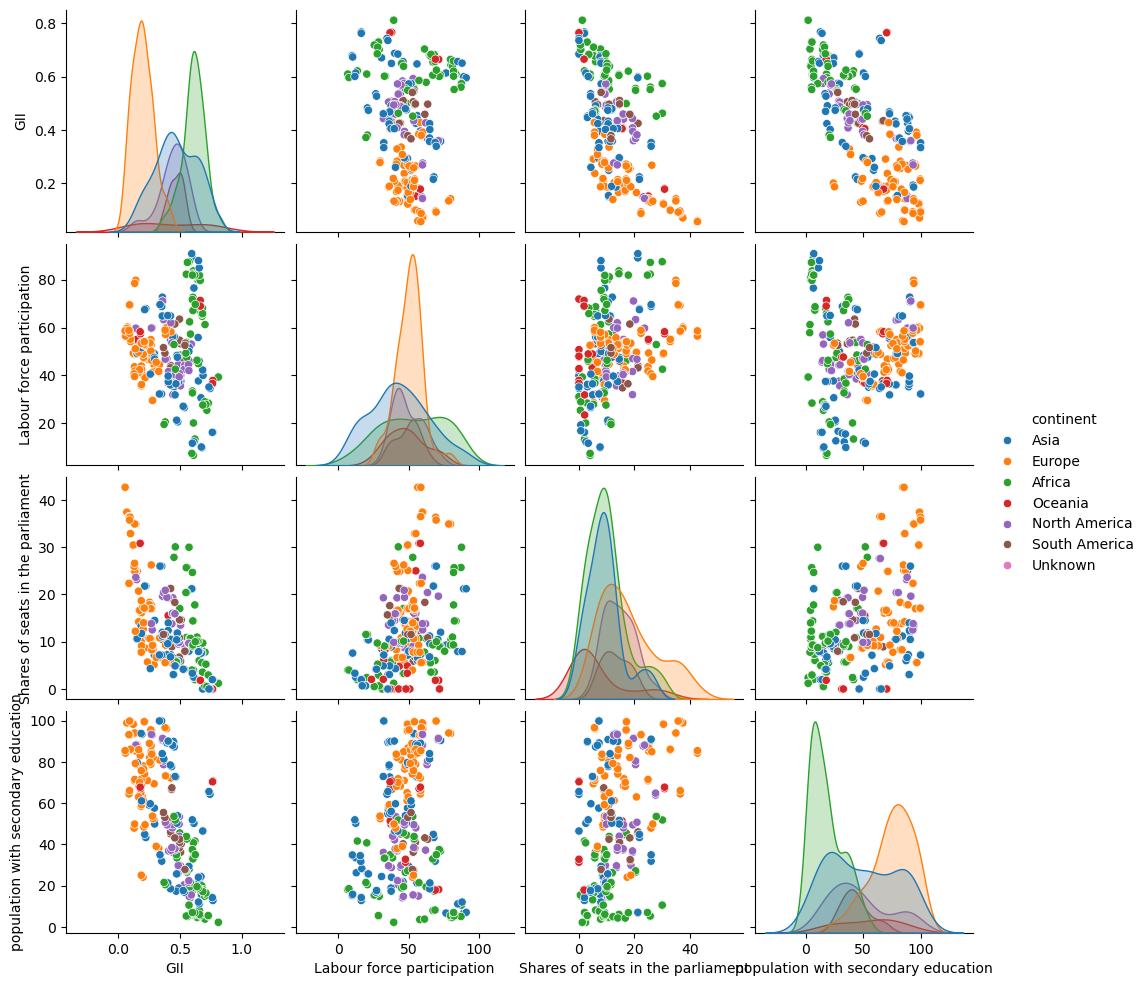

In [35]:
sns.pairplot(merged[['GII', 
                     'Labour force participation', 
                     'Shares of seats in the parliament', 
                     'population with secondary education', 
                     'continent']], 
             hue='continent')
plt.show()


In [37]:
import ipywidgets as widgets
from IPython.display import display

variables = ['Labour force participation',
             'Shares of seats in the parliament',
             'population with secondary education']

agg_df = merged.groupby('country')[variables + ['GII']].mean().reset_index()

for var in variables:
    min_val = agg_df[var].min()
    max_val = agg_df[var].max()
    agg_df[var] = (agg_df[var] - min_val) / (max_val - min_val)


def update_plot(w1, w2, w3):
    total = w1 + w2 + w3
    if total == 0:
        return
    w1, w2, w3 = w1/total, w2/total, w3/total

    agg_df['weighted_indecators'] = (w1*agg_df[variables[0]] +
                                    w2*agg_df[variables[1]] +
                                    w3*agg_df[variables[2]])
    
    corr = agg_df['weighted_indecators'].corr(agg_df['GII'])
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=agg_df, x='weighted_indecators', y='GII', s=100)
    plt.title(f'Weighted Indicators vs GII\nCorrelation: {corr:.2f}')
    plt.xlabel('Weighted Indicator')
    plt.ylabel('GII')
    plt.show()

w1_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Labour')
w2_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Parliament')
w3_slider = widgets.FloatSlider(value=0.34, min=0, max=1, step=0.05, description='Education')

sliders = widgets.VBox([w1_slider, w2_slider, w3_slider])
figure = widgets.interactive_output(update_plot, {'w1': w1_slider, 'w2': w2_slider, 'w3': w3_slider})

display(sliders, figure)


Output()

It probably makes sense to have a structure for the exploratory analysis and not just random action with data and visualizations. Maybe something like this:
1. basic stats & missing values (fill missing values or exclude?)
2. distributions and outliers (get a general idea for what values there are, are there crazy outliers)
3. somewhat summarize countries/continents and maybe decide on a limited number that we will continue exploring
4. correlation / trends in the data with plots to visualize 